In [1]:
!pip install xgboost catboost pandas scikit-learn gradio scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.8/321.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [2]:
!pip install scikit-learn gradio

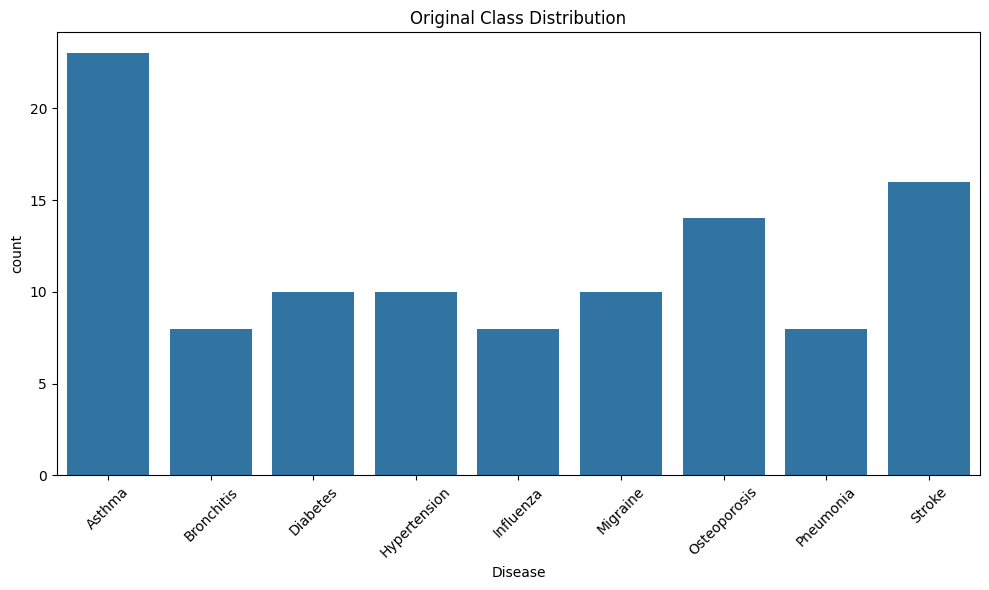

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Accuracy: 0.3030
Random Forest Accuracy: 0.3333


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:23:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.4242
CatBoost Accuracy: 0.4242
SVM Accuracy: 0.3030
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 39
[LightGBM] [Info] Number of data points in the train set: 74, number of used features: 10
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Wa

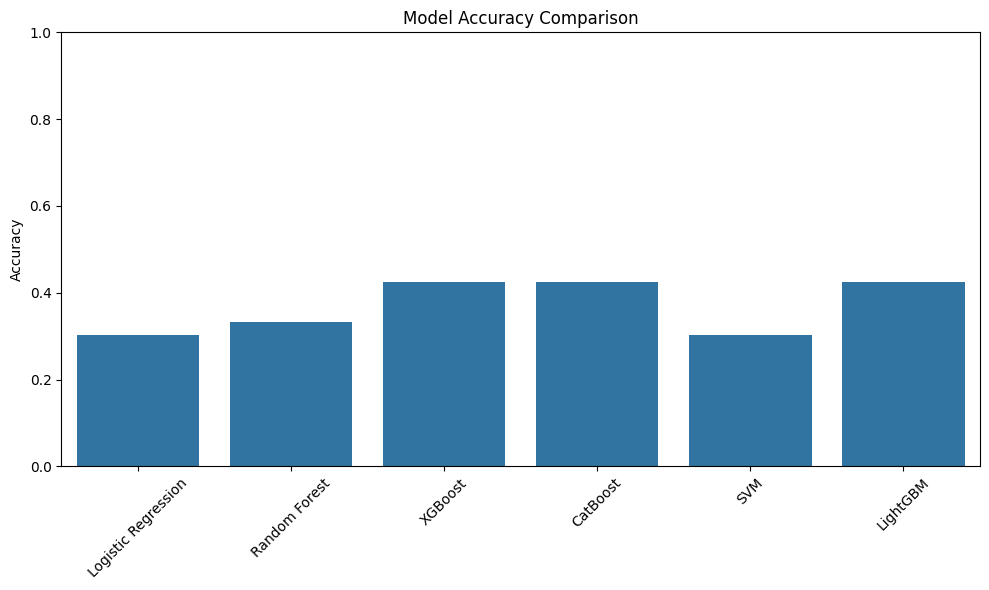

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d37bdc6c585a80b4d6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import gradio as gr

def load_and_preprocess_data(data_path):
    df = pd.read_excel(data_path)


    binary_cols = ['Fever', 'Cough', 'Fatigue', 'Difficulty Breathing']
    df[binary_cols] = df[binary_cols].apply(lambda x: x.map({'Yes': 1, 'No': 0}))


    categorical_mappings = {
        'Gender': {'Male': 0, 'Female': 1},
        'Blood Pressure': {'Low': 0, 'Normal': 1, 'High': 2},
        'Cholesterol Level': {'Low': 0, 'Normal': 1, 'High': 2},
        'Outcome Variable': {'Positive': 1, 'Negative': 0}
    }
    for col, mapping in categorical_mappings.items():
        df[col] = df[col].map(mapping)

    df['Risk Factor'] = (
        (df['Age'] > 60).astype(int) +
        (df['Blood Pressure'] == 2).astype(int) +
        (df['Cholesterol Level'] == 2).astype(int)
    )


    test_size = 0.3
    min_neighbors = 5
    min_samples = int(np.ceil(min_neighbors / (1 - test_size)))
    disease_counts = df['Disease'].value_counts()
    valid_diseases = disease_counts[disease_counts >= min_samples].index
    df = df[df['Disease'].isin(valid_diseases)]


    plot_class_distribution(df['Disease'], 'Original Class Distribution')


    return df

def train_disease_prediction_model(df):

    X = df.drop(columns=['Disease'])
    y = df['Disease']


    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)


    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
    )

    scaler = StandardScaler()
    numerical_cols = ['Age', 'Risk Factor']
    X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
        'CatBoost': CatBoostClassifier(silent=True, random_state=42),
        'SVM': SVC(probability=True, random_state=42, class_weight='balanced'),
        'LightGBM': LGBMClassifier(random_state=42, class_weight='balanced')
    }


    model_results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        model_results[name] = {'model': model, 'accuracy': accuracy}
        print(f"{name} Accuracy: {accuracy:.4f}")

    plot_model_performance(model_results)


    best_model_name = max(model_results, key=lambda x: model_results[x]['accuracy'])
    return model_results[best_model_name]['model'], scaler, X.columns.tolist(), numerical_cols, label_encoder

def predict_diseases(age, gender, fever, cough, fatigue, difficulty_breathing,
                    blood_pressure, cholesterol, model, scaler, feature_names,
                    numerical_cols, label_encoder):
    try:

        input_data = pd.DataFrame([{
            'Age': age,
            'Gender': 0 if gender == 'Male' else 1,
            'Fever': 1 if fever == 'Yes' else 0,
            'Cough': 1 if cough == 'Yes' else 0,
            'Fatigue': 1 if fatigue == 'Yes' else 0,
            'Difficulty Breathing': 1 if difficulty_breathing == 'Yes' else 0,
            'Blood Pressure': 0 if blood_pressure == 'Low' else (1 if blood_pressure == 'Normal' else 2),
            'Cholesterol Level': 0 if cholesterol == 'Low' else (1 if cholesterol == 'Normal' else 2),
            'Risk Factor': (age > 60) + (blood_pressure == 'High') + (cholesterol == 'High')
        }], columns=feature_names)


        input_data[numerical_cols] = scaler.transform(input_data[numerical_cols])


        probs = model.predict_proba(input_data)[0]
        results = sorted(zip(label_encoder.classes_, probs),
                        key=lambda x: x[1], reverse=True)[:5]

        return ", ".join([f"{disease} ({prob*100:.2f}%)" for disease, prob in results])

    except Exception as e:
        return f"Error: {str(e)}"

def plot_class_distribution(y, title):
    plt.figure(figsize=(10, 6))
    sns.countplot(x=y)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



def plot_model_performance(model_results):
    plt.figure(figsize=(10, 6))
    models = list(model_results.keys())
    accuracies = [model_results[m]['accuracy'] for m in models]
    sns.barplot(x=models, y=accuracies)
    plt.title('Model Accuracy Comparison')
    plt.ylim(0, 1)
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def main():

    df = load_and_preprocess_data('/content/disease_symptom_and_patient_profile_dataset_2.xlsx')


    model, scaler, features, num_cols, encoder = train_disease_prediction_model(df)


    inputs = [
        gr.Number(label="Age"),
        gr.Radio(["Male", "Female"], label="Gender"),
        gr.Radio(["Yes", "No"], label="Fever"),
        gr.Radio(["Yes", "No"], label="Cough"),
        gr.Radio(["Yes", "No"], label="Fatigue"),
        gr.Radio(["Yes", "No"], label="Difficulty Breathing"),
        gr.Radio(["Low", "Normal", "High"], label="Blood Pressure"),
        gr.Radio(["Low", "Normal", "High"], label="Cholesterol Level")
    ]

    iface = gr.Interface(
        fn=lambda *args: predict_diseases(*args, model, scaler, features, num_cols, encoder),
        inputs=inputs,
        outputs="text",
        title="Disease Prediction System",
        description="Predict top 5 likely diseases based on patient symptoms and profile"
    )

    iface.launch()

if __name__ == "__main__":
    main()